# Assignment 2: Machine Learning


You have 10 days to work on a machine learning algorithm.
I want you to pick one of the following use cases and make a prediction algorithm using either regression or classification algorithms.

Do the following:
1. Pick one use case (defined below).
    - We went with Use Case 2  
2. Explore and research which algorithm would work best for this use case (regression or classification)
    - Regression
3. Document your findings in a file (3-5 lines) on why you chose this algorithm.
    - We think Regression is the best in this case, seing as we are not looking for a binary value of higher or lower, but rather "how high" and "how low". We are looking for a nuanced value, and therefore regression in the best fit.
4. Train the algorithm using Python
    - Done
5. Keep the solution as simple as possible. We are not looking for the best machine learning algorithm. We are interested in seeing that you know how to work with machine learning.
    - Done
6. Publish the code on GitHub and send us the link
    - Sorta Done


## Use Case 2 - Predict passenger data for Ruter
Use the same data set given to you in assignment 1. I want you to make a prediction algorithm which predicts the number of passengers on a specific date for a specific bus (pick any one). Input should be date and output will be number of passengers
You should also show the  prediction percentage score. Data file: Ruter_data.csv


In [1]:
# Imports

# numpy for math
import numpy as np
# pandas for dataframes
import pandas as pd
#importing datetime for format conversion
import datetime as dt

#improts for plott
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")


# importing ai stuff
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# From some weird acticle about polynomial regression (sources further down where we actually implement things from the article)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
"""
First staring with making the .csv more manageable
"""

dataf = pd.read_csv("Ruter-data.csv", sep=";")

print(dataf["Linjenavn"].value_counts())
print(len(dataf.index))

100     465
110     362
390     247
31      220
360     189
       ... 
3772      1
3575      1
3833      1
3335      1
452       1
Name: Linjenavn, Length: 150, dtype: int64
6000


In [3]:
# We are only going to predict a single bus route, so dropping every other route, reducing from 6000 rows a smaller ammount of rows, you can edit linjenavn condition here to see predictions on other lines
dataf = dataf[dataf['Linjenavn'] == "100"]

# Also dropping negative passager values, as these must be sensor misreadings
dataf = dataf[dataf['Passasjerer_Ombord'] >= 0]


print(dataf["Linjenavn"].value_counts())
print(len(dataf.index))

100    423
Name: Linjenavn, dtype: int64
423


In [4]:
# Testing to see if any columns could be dropped

print(dataf["Fylke"].value_counts())
print(dataf["Område"].value_counts())
print(dataf["Kommune"].value_counts())
print(dataf["Linjetype"].value_counts())
print(dataf["Linjefylke"].value_counts())
print(dataf["Kjøretøy_Kapasitet"].value_counts())


# Seems like linjetype, linjefylke and kjøretøy kapasitet can be dropped, as they contain the same value across the board
# Linjenavn can also be dropped, as of course, that is the same in every value, we just need to remember that it was for bus 150 hahah

Viken    252
Oslo     171
Name: Fylke, dtype: int64
Nordøst     378
Indre By     45
Name: Område, dtype: int64
Lillestrøm    169
Alna          101
Lørenskog      83
Gamle Oslo     45
Stovner        19
Bjerke          6
Name: Kommune, dtype: int64
Lokal    423
Name: Linjetype, dtype: int64
Viken    423
Name: Linjefylke, dtype: int64
151    423
Name: Kjøretøy_Kapasitet, dtype: int64


In [5]:
dataf.drop({'Linjetype', 'Linjefylke', 'Kjøretøy_Kapasitet', 'Linjenavn'}, axis=1, inplace=True)

dataf.head(1)

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjeretning,Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Passasjerer_Ombord
38,10008-2020-08-09T11:24:00+02:00,09/08/2020,Viken,Nordøst,Lillestrøm,Sagdalen,Sagdalen skole,0,11:38:58,11:39:06,11:38:00,11:38:00,1


In [6]:
# Converting first to pandas time format, you can see the change in the Dato column, goes from "/" format to "-" format

dataf['Dato'] = pd.to_datetime(dataf['Dato'], errors='coerce')

dataf.head(1)

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjeretning,Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Passasjerer_Ombord
38,10008-2020-08-09T11:24:00+02:00,2020-09-08,Viken,Nordøst,Lillestrøm,Sagdalen,Sagdalen skole,0,11:38:58,11:39:06,11:38:00,11:38:00,1


In [7]:
# Turning the pandas datetime format to a number value, determining distance from the date "01.01.01"

dataf['Dato'] = dataf['Dato'].map(dt.datetime.toordinal)

dataf.head(1)

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjeretning,Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Passasjerer_Ombord
38,10008-2020-08-09T11:24:00+02:00,737676,Viken,Nordøst,Lillestrøm,Sagdalen,Sagdalen skole,0,11:38:58,11:39:06,11:38:00,11:38:00,1


In [8]:
# Setting data to a more sensible value, having day 1 being
# TODO: Might also have to group on date

# Figuring out the distance between dates based on max and min date 
print(max(dataf['Dato']) - min(dataf['Dato']))

# Storing this for later in case we want to correct the data back again
dateReduction = min(dataf['Dato']) - 1 

# Like this, first date should have a value of 1
dataf['Dato'] = dataf['Dato'] - dateReduction 

# Checking that we do not in fact have a 0 value
print(min(dataf['Dato'])) 

337
1


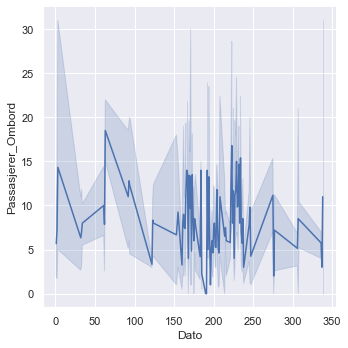

In [9]:
# Task is to predict passengers per day, so doing a quick relplot thus far

sns.relplot(x="Dato", y="Passasjerer_Ombord", kind="line", data=dataf)

# Guessing that the lack of precission is due to lack of grouping

In [10]:
# We see that a lot of days have multiple counts, and we need to group them, 110 rows are spread over 43 unique dates
print(len(dataf["Dato"].value_counts()))

90


In [11]:
"""
Sources that helped with this grouping and such:
https://www.geeksforgeeks.org/pandas-groupby/?ref=lbp
https://towardsdatascience.com/all-pandas-groupby-you-should-know-for-grouping-data-and-performing-operations-2a8ec1327b5

Espescially this one:
https://www.askpython.com/python-modules/pandas/conditionally-grouping-values

https://stackoverflow.com/questions/26323926/pandas-groupby-agg-how-to-return-results-without-the-multi-index
"""

"""
We went with using mean instead of sum, as there were super unreliable data in this dataset. Some days have no recordings, other have a few, but none have the actual data, containing every trip for every bus in that line, on a given day. Therefore it would not make sense to sum the passengers together as the sums would mean nothing without complete data
"""
dataf2 = dataf.groupby('Dato', axis=0, as_index=False).median()
dataf = dataf.groupby('Dato', axis=0, as_index=False).mean()

#engineering feature for weekday
dataf['Ukedag'] = dataf['Dato'] % 7
dataf2['Ukedag'] = dataf2['Dato'] % 7

# Adding 1 to every weekday to hinder zero values
dataf['Ukedag'] = dataf['Ukedag'] + 1
dataf2['Ukedag'] = dataf2['Ukedag'] + 1

# dataf = dataf['Passasjerer_Ombord'].agg(np.mean)

"""
btw, either i did something massively wrong, or like this dataset is quite lacking, it doesn't even have daily entries on this bus, that goes like 4 times per hour every day, what is that all about?
"""

dataf

,Dato,Linjeretning,Passasjerer_Ombord,Ukedag
0,1,0.666667,5.666667,2
1,2,0.571429,7.285714,3
2,3,0.666667,14.333333,4
3,32,0.333333,6.333333,5
4,33,0.363636,7.000000,6
...,...,...,...,...
85,307,0.250000,8.500000,7
86,308,0.600000,8.400000,1
87,336,0.500000,5.750000,1
88,337,1.000000,3.000000,2


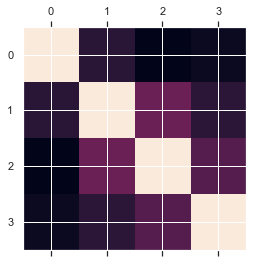

,Dato,Linjeretning,Passasjerer_Ombord,Ukedag
Dato,1.000000,-0.007989,-0.132578,-0.095265
Linjeretning,-0.007989,1.000000,0.178383,0.004452
Passasjerer_Ombord,-0.132578,0.178383,1.000000,0.119183
Ukedag,-0.095265,0.004452,0.119183,1.000000


In [12]:
# Just quickly checking for any correlation

corrMatrix = dataf.corr()
plt.matshow(corrMatrix)
plt.show()

corrMatrix.style.background_gradient(cmap='coolwarm')

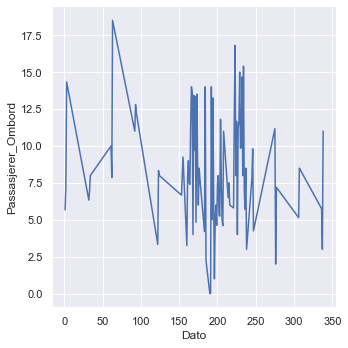

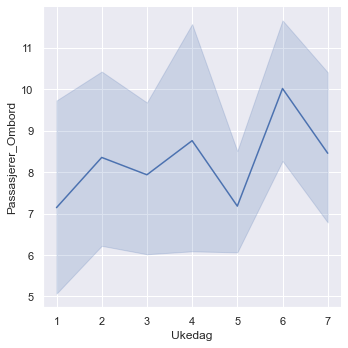

In [13]:
sns.relplot(x="Dato", y="Passasjerer_Ombord", kind="line", data=dataf)
sns.relplot(x="Ukedag", y="Passasjerer_Ombord", kind="line", data=dataf)


# even thought the other columns got a bit scuffed, then we see that the plot itself becomes much cleaner
# Grouping on weekday might give us better values for regression algorithm

In [14]:
"""
THIS IS THE PART WHERE WE STEAL EVERYTHING FROM LAB 4
Source: https://github.com/umaimehm/Intro_to_AI_2021/tree/main/Lab4
"""

"""
Setting x to be weekday
y to be passengers
"""

# setting up columns for training
X = pd.DataFrame(dataf['Dato']) #Var1
X1 = pd.DataFrame(dataf['Ukedag']) #Var1

y = pd.DataFrame(dataf['Passasjerer_Ombord']) #Result

# Splitting x and y columns to into test and train sub sets of the actual columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.33, random_state=42)

In [15]:
#Date stuff
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
Y_pred = linear_regressor.predict(X_train)


#Weekday stuff
linear_regressor1 = LinearRegression()
linear_regressor1.fit(X1_train, y1_train)
Y1_pred = linear_regressor.predict(X1_train)

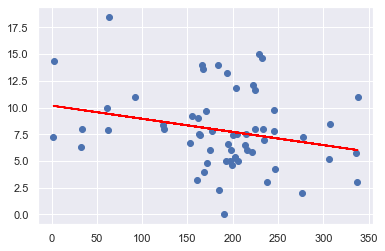

MSE = 12.349483126587252


In [16]:
#Plotting day model
plt.scatter(X_train, y_train)
plt.plot(X_train, Y_pred, color='red')
plt.show()
print( "MSE = "+str(metrics.mean_squared_error(y_train,Y_pred))) #Calculate MSE

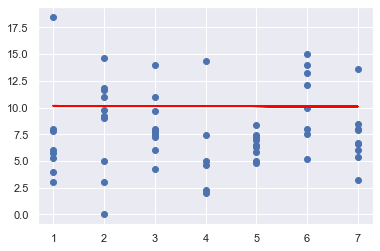

MSE = 18.36547950487494


In [17]:
#Plotting weekday model
plt.scatter(X1_train, y1_train)
plt.plot(X1_train, Y1_pred, color='red')
plt.show()
print( "MSE = "+str(metrics.mean_squared_error(y1_train,Y1_pred))) #Calculate MSE

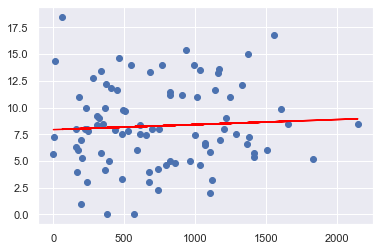

MSE = 14.778905173008802


In [18]:
# plotting combination model, inspired by lab 4
dataf['UkeDato'] = dataf['Dato']*dataf['Ukedag']

X = pd.DataFrame(dataf['UkeDato'])
Y = pd.DataFrame(dataf['Passasjerer_Ombord'])
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()
print( "MSE = "+str(metrics.mean_squared_error(Y,Y_pred)))

In [19]:
# This is where we show how we predict stuff, as the use case asks us to do

linear_regressor.predict([[500*5]]) #Expected output = 9-10ish, passengers for that day, as it is far into the future and the line is slowly climbing

array([[9.11373118]])

In [20]:
df2_sort = dataf2.sort_values('Dato')
df2_sort['Dato'].value_counts()
#df2_sort

1      1
228    1
226    1
225    1
224    1
      ..
171    1
170    1
169    1
168    1
338    1
Name: Dato, Length: 90, dtype: int64

In [34]:
# Quick test of polynomial regression
# Couldn't quite figure it out whoups
# Source (Open in private window to avoid paywall): https://towardsdatascience.com/polynomial-regression-with-scikit-learn-what-you-should-know-bed9d3296f2
from sklearn.preprocessing import StandardScaler

# 

X = pd.DataFrame(dataf2['Dato'])
X_sort = X.sort_values('Dato')
y = pd.DataFrame(dataf2['Passasjerer_Ombord'])

scaler = StandardScaler()
# 4th degree polynomial
poly = PolynomialFeatures(7)

# skipped using these values for some reason, decided to just run it on entire column
X_train, X_test, y_train, y_test = train_test_split(X_sort, y, test_size=0.33, random_state=42)
X_train = X_train.sort_values('Dato')

xPoly = poly.fit_transform(X_train)
poly.fit(X_train, y_train)

model = LinearRegression()
model.fit(xPoly, y_train)

y_pred = model.predict(poly.fit_transform(X_train))
y_pred2 = model.predict(poly.fit_transform(X_test))

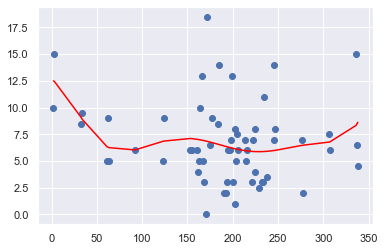

MSE = 12.279669608600207


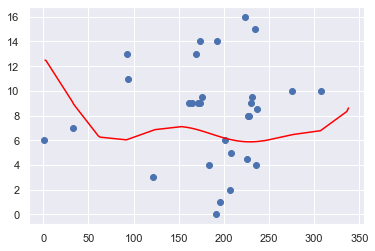

MSE = 21.708962232024636


In [35]:
# Doing the plots for the polynomial model

plt.scatter(X_train, y_train)               
plt.plot(X_train, y_pred, color='red')
plt.show()                           
print( "MSE = "+str(metrics.mean_squared_error(y_train,y_pred)))

plt.scatter(X_test, y_test)               
plt.plot(X_train, y_pred, color='red')
plt.show()                           
print( "MSE = "+str(metrics.mean_squared_error(y_test,y_pred2)))

In [23]:
# Doing various predicts so see how our model thinks the future will be

print(model.predict(poly.fit_transform([[300]])))
print(model.predict(poly.fit_transform([[500]])))
print(model.predict(poly.fit_transform([[550]])))
print(model.predict(poly.fit_transform([[600]])))
print(model.predict(poly.fit_transform([[650]])))
print(model.predict(poly.fit_transform([[700]])))
print(model.predict(poly.fit_transform([[750]])))
print(model.predict(poly.fit_transform([[800]])))
print(model.predict(poly.fit_transform([[850]])))
print(model.predict(poly.fit_transform([[3000]])))

"""
print(model.predict(poly.fit_transform([[0]])))
print(model.predict(poly.fit_transform([[1]])))
print(model.predict(poly.fit_transform([[2]])))
print(model.predict(poly.fit_transform([[3]])))
print(model.predict(poly.fit_transform([[4]])))
print(model.predict(poly.fit_transform([[5]])))
print(model.predict(poly.fit_transform([[6]])))
"""

# these values are not very good, not quite sure why but we think it has something to do with the polynomial having some wild turns futher out in the "future" / positive x values

[[5.913727]]
[[4.36606662]]
[[3.97915153]]
[[3.59223644]]
[[3.20532134]]
[[2.81840625]]
[[2.43149115]]
[[2.04457606]]
[[1.65766097]]
[[-14.97968808]]


'\nprint(model.predict(poly.fit_transform([[0]])))\nprint(model.predict(poly.fit_transform([[1]])))\nprint(model.predict(poly.fit_transform([[2]])))\nprint(model.predict(poly.fit_transform([[3]])))\nprint(model.predict(poly.fit_transform([[4]])))\nprint(model.predict(poly.fit_transform([[5]])))\nprint(model.predict(poly.fit_transform([[6]])))\n'

# Conclusion

With a limited dataset, our reading become quite bad, and our prediction limited in quality.

However, i think that we did all the steps the right way, so if we were given a more complete dataset, then things could probably get a bit better

I think we answered the task properly, trained and predicted via linear regression.

Tried to use a polynomial fit, but it didn't quite work out, somehow got a circular line? So just ignore those parts, kept them in to show our efforts